### Causal AI
<img src="https://s7d1.scene7.com/is/content/dmqualcommprod/AI%20Causality%20Cow_OnQ_Inline_1" alt="qualcomm" width="400" align="left"/>

Image Source:
    
https://www.qualcomm.com/news/onq/2022/09/is-causality-the-missing-piece-of-the-ai-puzzle-

#### Libraries and config

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

In [2]:
# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

#### Logging

In [3]:
# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

#### Load data

In [4]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4    v0  \
0  1.294655  1.0  0.805670 -1.730791  0.007817  3.121658  1.060456  2  True   
1 -0.052011  1.0  0.360425 -0.037868  2.577100  1.489487 -1.500106  1  True   
2 -0.727766  1.0  0.804055  0.789798 -0.018432  0.886954 -0.669500  1  True   
3 -0.956969  0.0  0.496967  0.848609  0.980360  0.961966 -0.625440  0  True   
4  0.877318  1.0  0.424383  0.599083  1.753924 -0.645939 -1.400875  3  True   

           y  
0  23.396014  
1  16.877492  
2  11.231807  
3   8.710513  
4  24.054770  
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ 

In [5]:
df.head() # nicer

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.294655,1.0,0.805670,-1.730791,0.007817,3.121658,1.060456,2,True,23.396014
1,-0.052011,1.0,0.360425,-0.037868,2.577100,1.489487,-1.500106,1,True,16.877492
2,-0.727766,1.0,0.804055,0.789798,-0.018432,0.886954,-0.669500,1,True,11.231807
3,-0.956969,0.0,0.496967,0.848609,0.980360,0.961966,-0.625440,0,True,8.710513
4,0.877318,1.0,0.424383,0.599083,1.753924,-0.645939,-1.400875,3,True,24.054770


In [6]:
len(df)

#### Interface 1 (recommended): Input causal graph

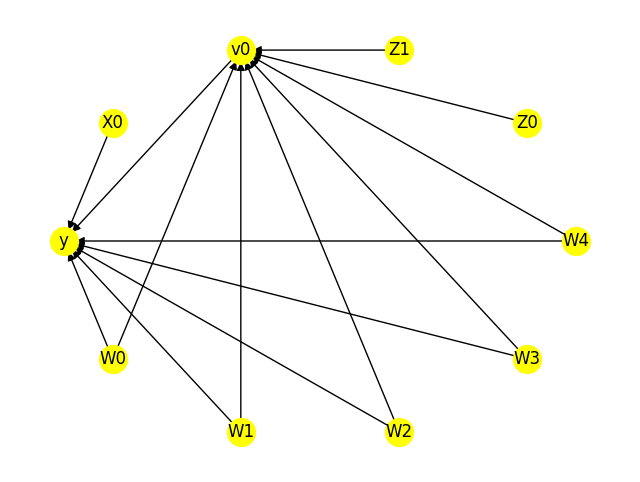

In [7]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

model.view_model()

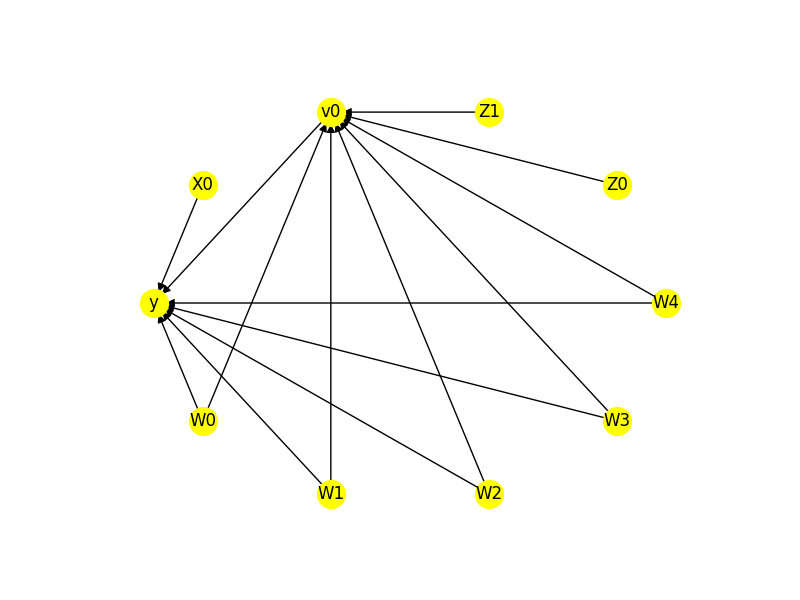

In [8]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

#### Identification

DoWhy philosophy: Keep identification and estimation separate

Identification can be achieved without access to the data, acccesing only the graph. 

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True) # parameter here means ignore any unobserved confounding
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Estimation

In [10]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

## Realized estimand
b: y~v0+W2+W1+W3+W0+W4
Target units: ate

## Estimate
Mean value: 11.741412508625785

Causal Estimate is 11.741412508625785


#### Causal effect on the control group (ATC)

difference between here and last code is limiting focus to target units as a control group (ATC), rather than all units/groups

In [11]:
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

## Realized estimand
b: y~v0+W2+W1+W3+W0+W4
Target units: atc

## Estimate
Mean value: 11.728028126432987

Causal Estimate is 11.728028126432987


#### Interface 2: Specify common causes and instruments

NB below results in same graph just that input is expressed as causes and instruments rather than input graph

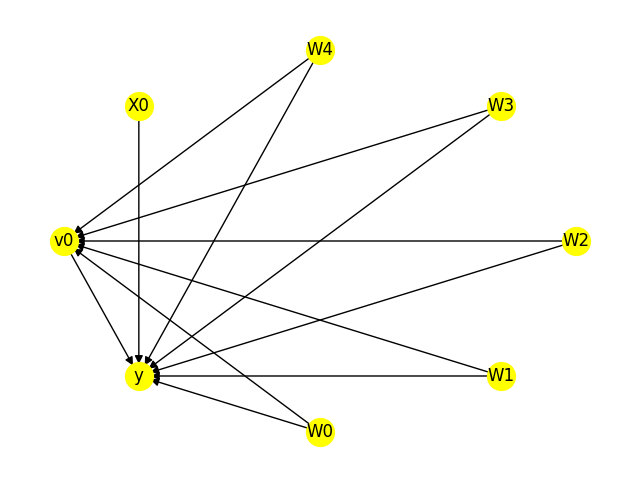

In [12]:
# Without graph
model= CausalModel(
        data=df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])

model.view_model()

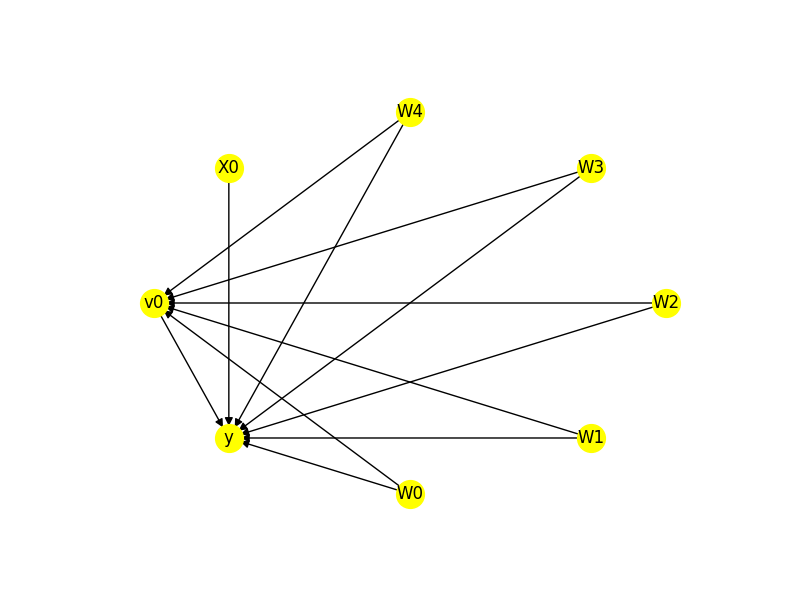

In [13]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

#### Identification & estimation

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [15]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

## Realized estimand
b: y~v0+W2+W1+W3+W0+W4
Target units: ate

## Estimate
Mean value: 11.741412508625785

Causal Estimate is 11.741412508625785


same result as when we applied to all groups, not just control group...

#### Refuting the estimate

Refutation methods provide tests that every correct estimator should pass. 

So if an estimator fails the refutation test (p-value is <0.05), then it means that there is some problem with the estimator.

##### 1) Invariant transformations

these are changes in the data that should not change the estimate above 
    
Any estimator whose result varies significantly between the original data and the modified data fails the test;

###### Adding a random common cause variable

In [16]:
# NB this may take 2 mins to run...

res_random=model.refute_estimate(identified_estimand, estimate, 
                                 method_name="random_common_cause") # NB use random_seed = 1 if need to reproduce results
print(res_random)

Refute: Add a random common cause
Estimated effect:11.741412508625785
New effect:11.74141250862578
p value:2.0



similar "New" effect to previous Causal Estimate

###### Removing a random subset of the data

In [17]:
# NB this may take 2 mins to run...

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)  # NB use random_seed = 1 if need to reproduce results
print(res_subset)


Refute: Use a subset of data
Estimated effect:11.741412508625785
New effect:11.750495055709068
p value:0.96



again similar to previous Causal Estimate

so whether we adding a random variable or remove a random subset, in both cases effect is similar to original Causal Estimate

##### 2) Nullifying transformations

these are transformations that should result in a zero causal true estimate after data is changed 
    
Any estimator whose result varies significantly from zero on the new data fails the test.

###### Replacing treatment with a random (placebo) variable

replacement with a random (placebo) variable is an example of a nullifying transformation...

In [18]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.741412508625785
New effect:0.0819522017024941
p value:0.82



effect close to zero as you should expect from a placebo treatment

Further references:

https://www.pywhy.org/dowhy/v0.8/example_notebooks/dowhy_simple_example.html

#### Questions / Follow-up

contact ce.tech

<img src="ce.tech.png" alt="ce.tech" width="200" align="left"/>